In [23]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

np.random.seed(0)

In [24]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']),
    "font.serif": ['Palatino',
                   'Palatino Linotype',
                   'Palatino LT STD',
                   'Book Antiqua',
                   'Georgia',
                   'DejaVu Serif'],
    'font.family': 'serif',
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 1.0,
})

In [25]:
returns = pd.read_csv(pm.get_data("SP500.csv"), index_col='Date')
returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()
returns.head()

,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


/Users/evan/monte-carlo/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


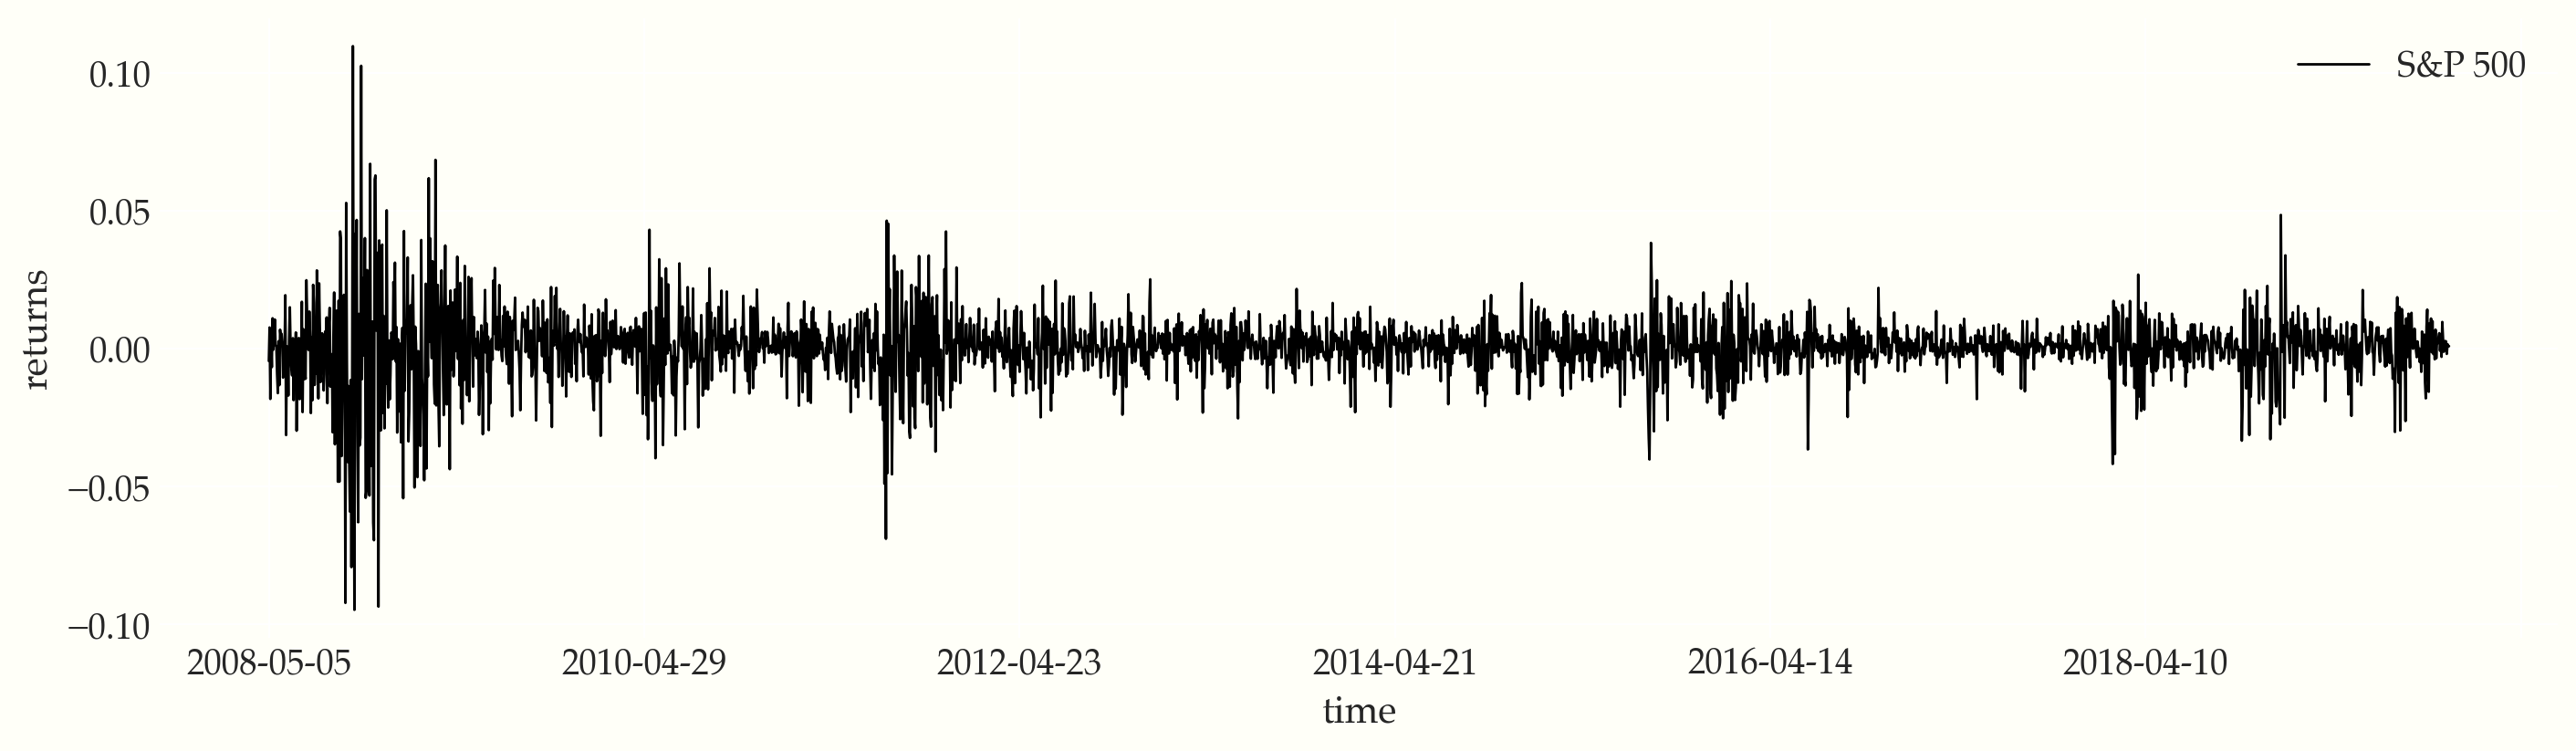

In [26]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label='S&P 500', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();

In [27]:
def make_stochastic_volatility_model(data):
    with pm.Model() as model:
        step_size = pm.Exponential('step_size', 10)
        volatility = pm.GaussianRandomWalk('volatility', sigma=step_size, shape=len(data))
        nu = pm.Exponential('nu', 0.1)
        returns = pm.StudentT('returns',
                        nu=nu,
                        lam=np.exp(-2*volatility),
                        observed=data["change"])
    return model

stochastic_vol_model = make_stochastic_volatility_model(returns)

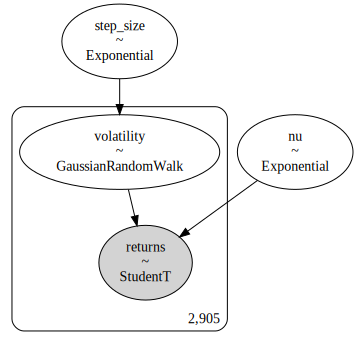

In [28]:
pm.model_to_graphviz(stochastic_vol_model)

In [29]:
with stochastic_vol_model:
    prior = pm.sample_prior_predictive(500)

/Users/evan/monte-carlo/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


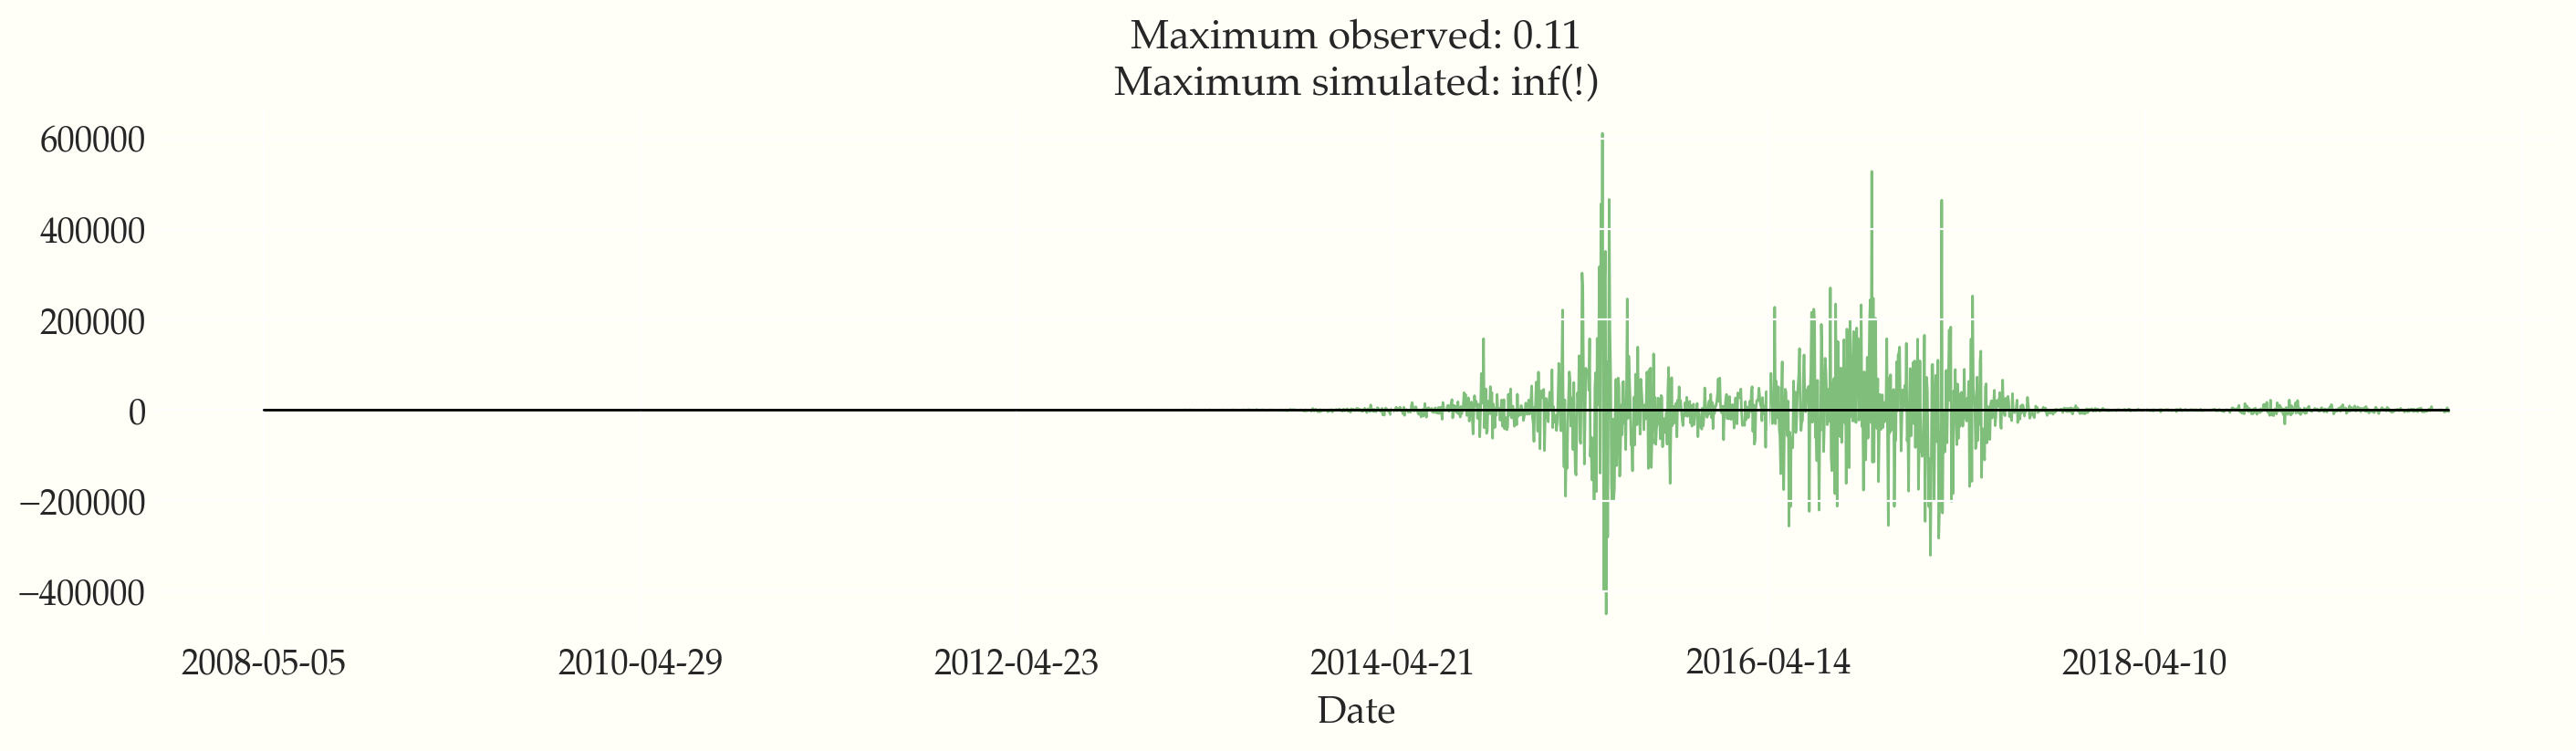

In [30]:
fig, ax = plt.subplots(figsize=(14, 4))
returns['change'].plot(ax=ax, lw=1, color='black')
ax.plot(prior['returns'][4:6].T, 'g', alpha=0.5, lw=1, zorder=-10)

max_observed, max_simulated = np.max(np.abs(returns['change'])), np.max(np.abs(prior['returns']))
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [31]:
with stochastic_vol_model:
    trace = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 223 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
with stochastic_vol_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

/Users/evan/monte-carlo/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


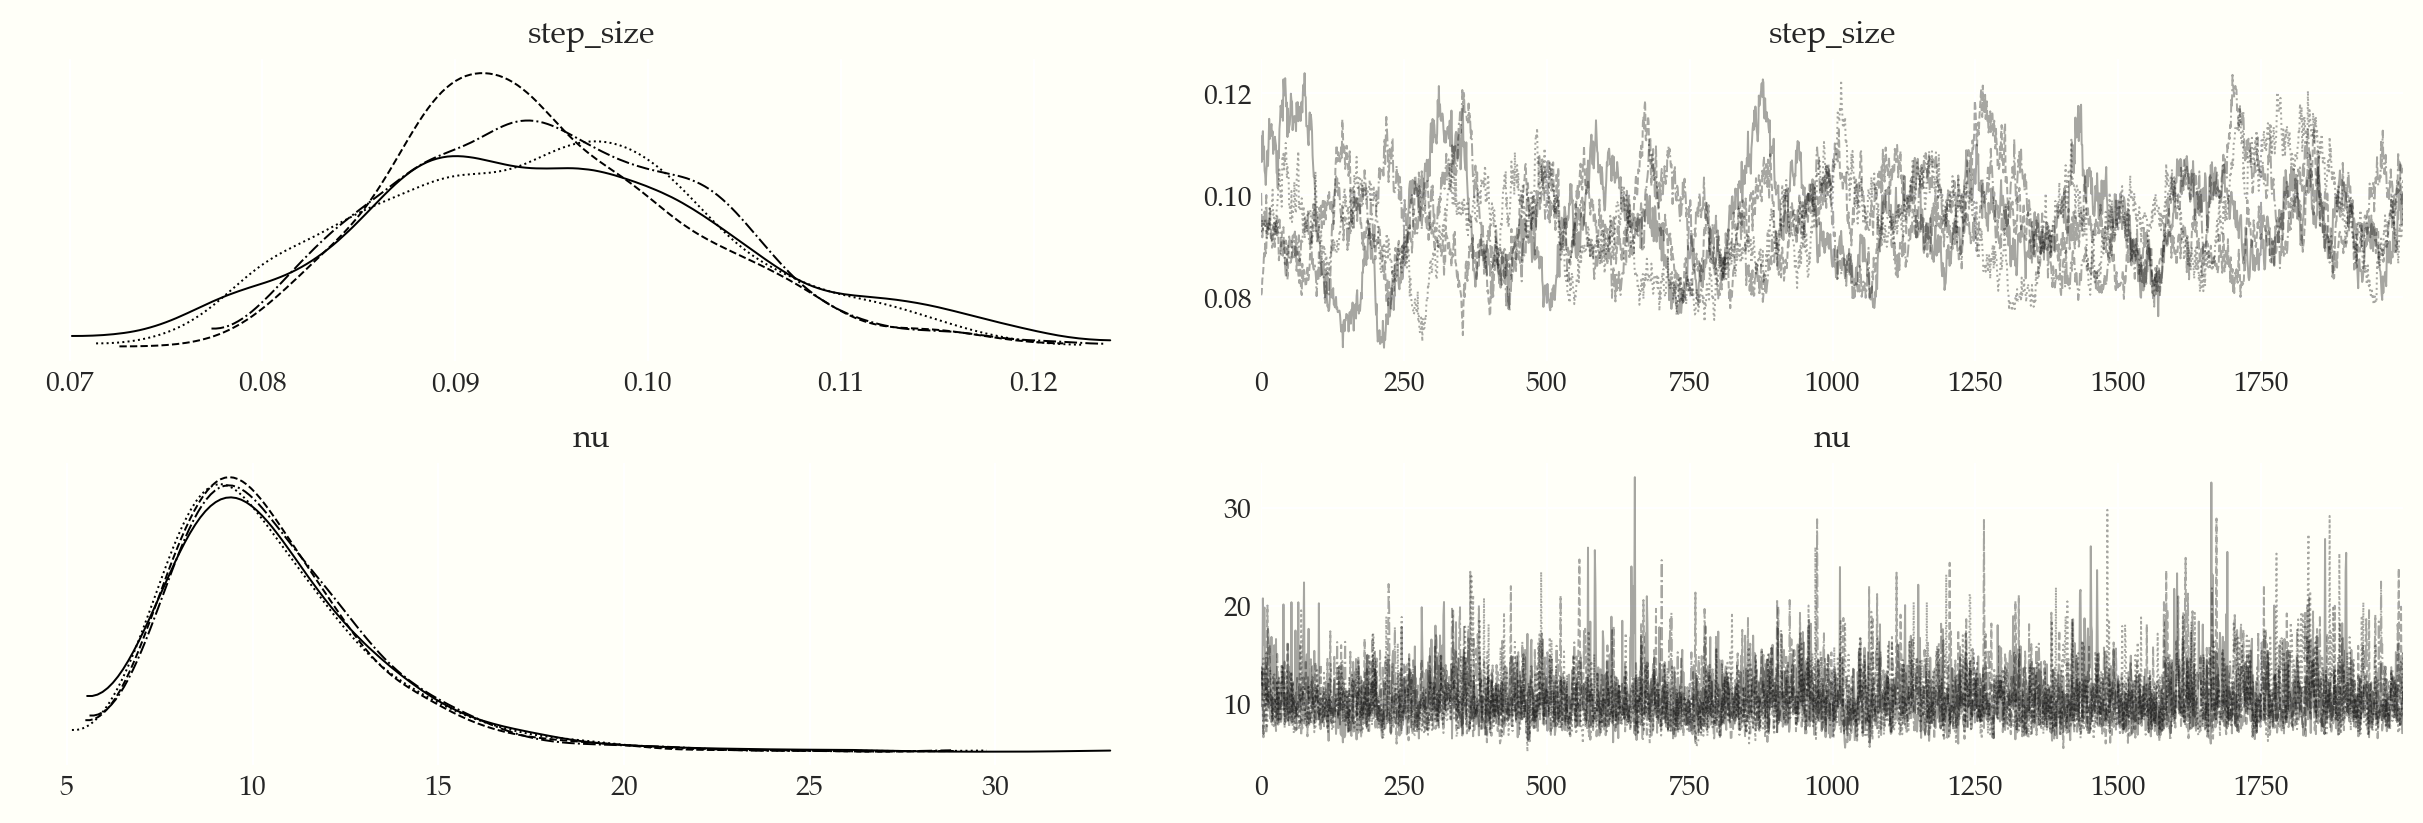

In [20]:
pm.traceplot(trace, var_names=['step_size', 'nu']);

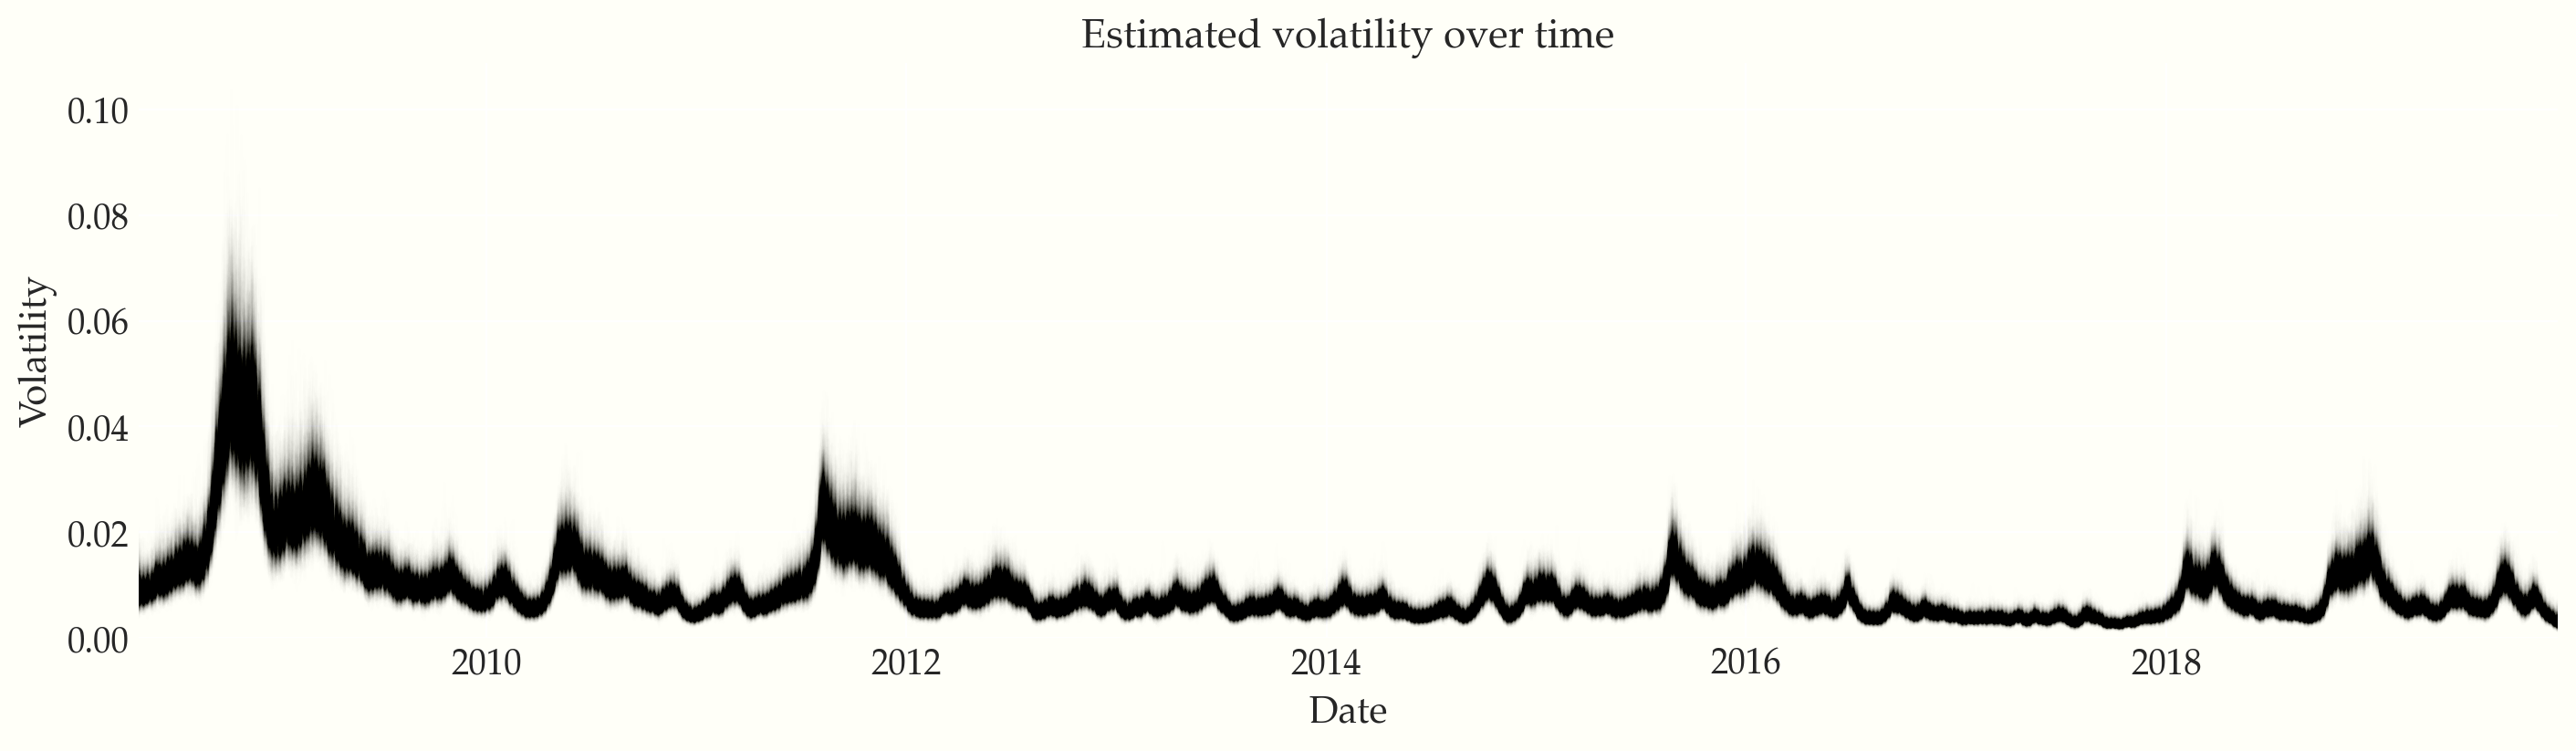

In [21]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = np.exp(trace['volatility'])[::5].T
x_vals = np.vstack([returns.index for _ in y_vals.T]).T.astype(np.datetime64)

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Estimated volatility over time', xlabel='Date', ylabel='Volatility');

/Users/evan/monte-carlo/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


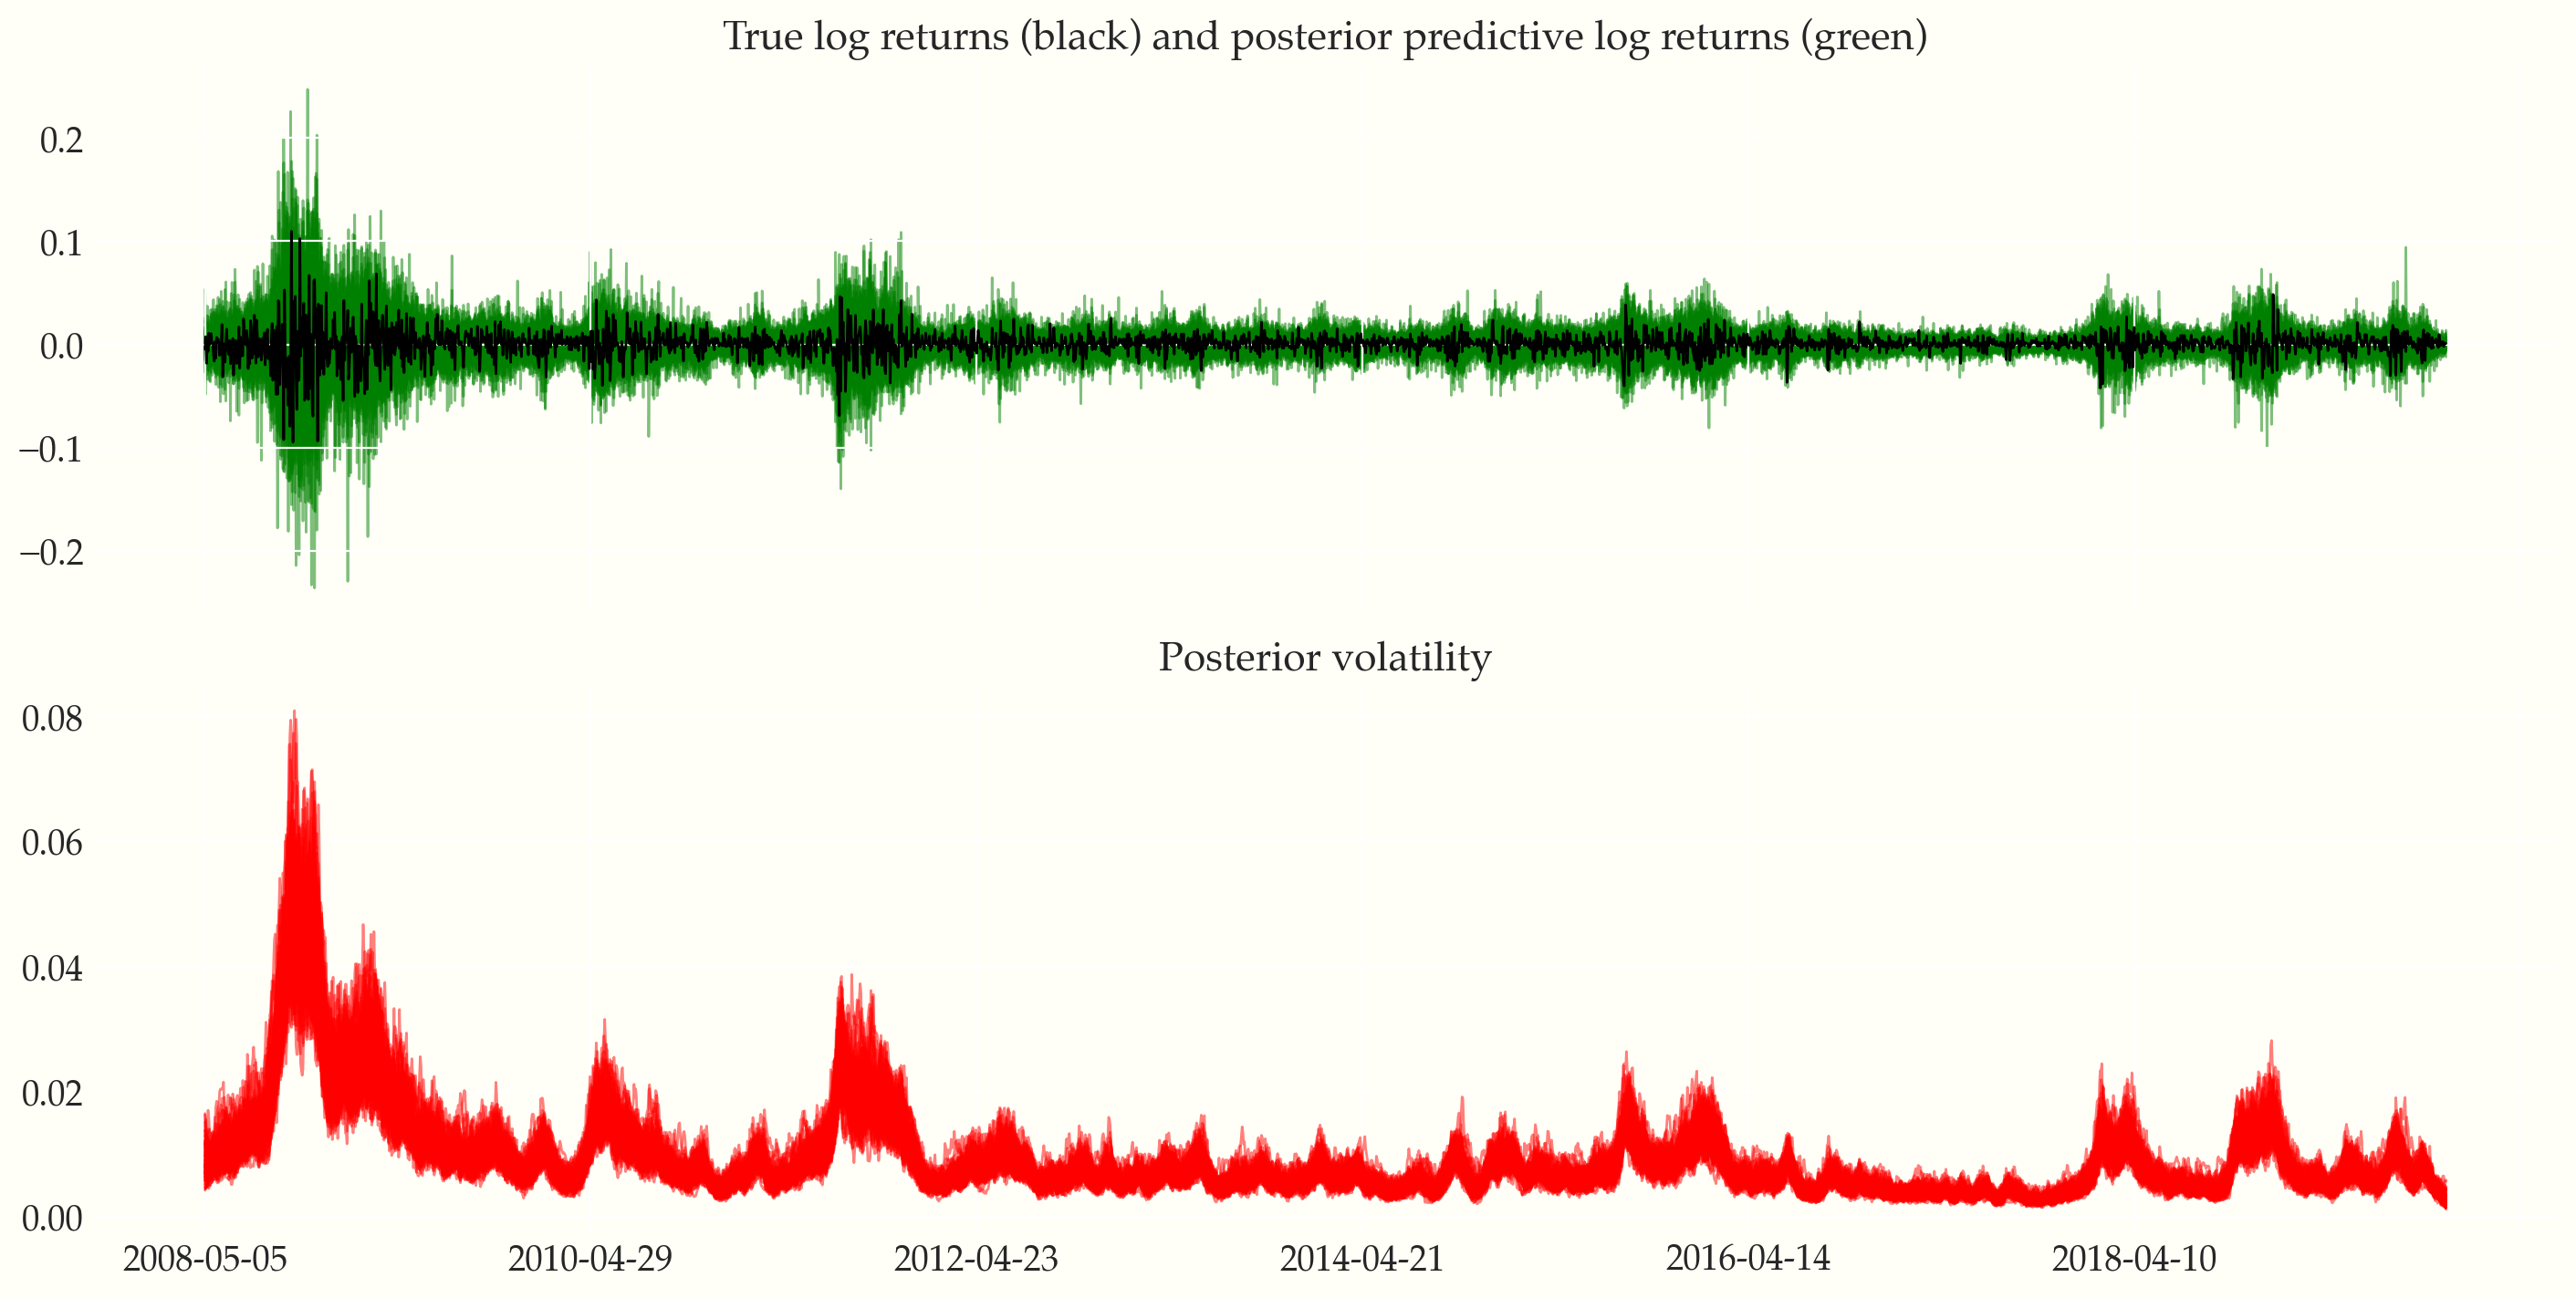

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns['change'].plot(ax=axes[0], color='black')

axes[1].plot(np.exp(trace['volatility'][::100].T), 'r', alpha=0.5)
axes[0].plot(posterior_predictive['returns'][::100].T, 'g', alpha=0.5, zorder=-10)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");